# Домашнее задание к занятию 10
1. Попробуйте попарно сравнить между собой 4,5,10,20 нормально распределенных
выборок с равным средним и сигмой без использования поправок. Что получилось?
(Сравнение с помощью t-test)
Тоже самое сделайте для ненормально распределенных выборок (можете использовать
Манна Уитни, или другой критерий, если это будет обоснованно).
2. Сравните больше 10 выборок с неравными средними и сигмой между собой, используя
поправку Бонферрони (разницу можете пробовать любую, от небольшой до реально
большого различия). Что получилось? А теперь сравните результат со сравнением того
же числа выборок, но используя поправку Холма - Бонферрони.
Можете использовать любые библиотеки.

## Without corrections

In [3]:
import numpy as np
import pandas as pd

In [4]:
def generate_normal_sample(size = 100, mu = 7, sigma = 1):
    return np.random.normal(mu, sigma, size)

# unnormal distribution
def generate_fisher_sample(size = 100, dfnum = 2, dfden = 5):
    return np.random.f(dfnum, dfden, size)

In [30]:
import plotly.express as px

In [31]:
fig = px.histogram(generate_normal_sample(10000), nbins=200)
fig.show()

In [32]:
fig = px.histogram(generate_fisher_sample(10000), nbins=200, range_x = [0, 100])
fig.show()

### normal

In [7]:
from scipy import stats

In [158]:
def paired_ttest(n = 5, each_sample_size = 100, alpha = 0.05):
    samples = [(i, generate_normal_sample(size = each_sample_size)) for i in range(n)]
    diff_samples = []
    eq_samples = []
    for sample in samples:
        for i in range(sample[0] + 1, len(samples)):
            sample_ = samples[i]
            if sample[0] != sample_[0]:
                t, p_val = stats.ttest_ind(sample[1], sample_[1])
                if p_val < alpha:
                    diff_samples.append((sample[0], sample_[0], p_val))
                else:
                    eq_samples.append((sample[0], sample_[0], p_val))
    
    return diff_samples, eq_samples

Количество сравнений прямо пропорционально количеству ошибок 1 рода:

In [35]:
m_diff_stat = []
for i in range(15):
    diff_stat = []
    for _ in range(100):
        diff_samples, eq_samples = paired_ttest(n = i+1, each_sample_size = 100)
        diff_stat.append(len(diff_samples))
    m_diff_stat.append(np.mean(diff_stat))

<AxesSubplot:>

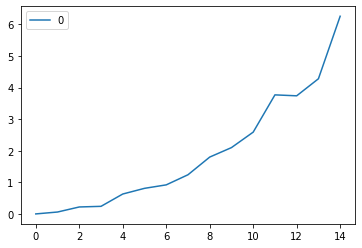

In [36]:
pd.DataFrame(m_diff_stat).plot()

Размер самих выборок, при фиксированном количестве попарных сравнений не влияет на количество ошибок 1 рода:

In [37]:
m_diff_stat = []
for i in range(10):
    diff_stat = []
    for _ in range(100):
        diff_samples, eq_samples = paired_ttest(n = 10, each_sample_size = 100*(i+1))
        diff_stat.append(len(diff_samples))
    m_diff_stat.append(np.mean(diff_stat))

<AxesSubplot:>

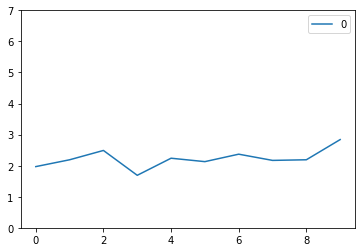

In [38]:
pd.DataFrame(m_diff_stat).plot(ylim = (0, 7))

Выяснить почему размер самих выборок, при фиксированном количестве попарных сравнений не влияет на количество ошибок 1 рода !

### unnormal

In [39]:
def paired_mannwhitney_test(n = 5, each_sample_size = 100):
    samples = [(i, generate_fisher_sample(size = each_sample_size)) for i in range(n)]
    diff_samples = []
    eq_samples = []
    for sample in samples:
        for i in range(sample[0] + 1, len(samples)):
            sample_ = samples[i]
            if sample[0] != sample_[0]:
                t, p_val = stats.mannwhitneyu(sample[1], sample_[1])
                if p_val < 0.05:
                    diff_samples.append((sample[0], sample_[0], p_val))
                else:
                    eq_samples.append((sample[0], sample_[0], p_val))
    
    return diff_samples, eq_samples

In [40]:
m_diff_stat = []
for i in range(15):
    diff_stat = []
    for _ in range(100):
        diff_samples, eq_samples = paired_mannwhitney_test(n = i+1, each_sample_size = 100)
        diff_stat.append(len(diff_samples))
    m_diff_stat.append(np.mean(diff_stat))

<AxesSubplot:>

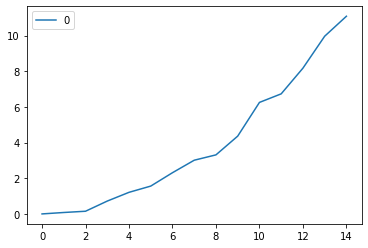

In [41]:
pd.DataFrame(m_diff_stat).plot()

In [42]:
m_diff_stat = []
for i in range(15):
    diff_stat = []
    for _ in range(100):
        diff_samples, eq_samples = paired_ttest(n = 10, each_sample_size = 100*(i+1))
        diff_stat.append(len(diff_samples))
    m_diff_stat.append(np.mean(diff_stat))

<AxesSubplot:>

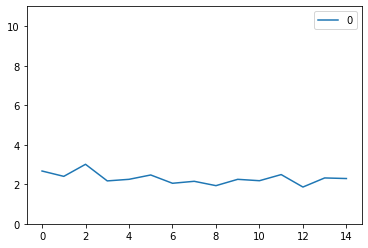

In [43]:
pd.DataFrame(m_diff_stat).plot(ylim = (0, 11))

## With corrections

### Bonferrony

Нагенерируем 8 равных между собой выборок и 1 выборку, которая будут сильно отличаться от остальных и 1 которая будет оочень сильно отличаться от остальных

In [186]:
n = 5
samples = []
samples.append((0, generate_normal_sample(size = 100, mu = 7.35, sigma = 1)))
for i in range(n-2):
    samples.append((i+1, generate_normal_sample(size = 100, mu = 7, sigma = 1)))
samples.append((n-1, generate_normal_sample(size = 100, mu = 2, sigma = 3)))

Убедимся в их различиях парочкой простых т-тестов

In [187]:
t, p = stats.ttest_ind(samples[0][1], samples[1][1])
print(p)

0.0007647564552694327


In [188]:
t, p = stats.ttest_ind(samples[3][1], samples[4][1])
print(p)

1.3298083472620394e-40


In [189]:
t, p = stats.ttest_ind(samples[8][1], samples[9][1])
print(p)

IndexError: list index out of range

In [190]:
n = len(samples)
comp_cnt = sum(n - (i+1) for i in range(n)) # кол-во попарных сравнений
comp_cnt

10

Попробуем теперь найти эти различия при множественном сравнении всех с консервативной поправкой Бонферрони

In [191]:
alpha = 0.05
diff_samples = []
eq_samples = []
pvals = []
for sample in samples:
    for i in range(sample[0] + 1, len(samples)):
        sample_ = samples[i]
        if sample[0] != sample_[0]:
            t, p_val = stats.ttest_ind(sample[1], sample_[1])
            if p_val < alpha / comp_cnt:
                diff_samples.append((sample[0], sample_[0], p_val))
            else:
                eq_samples.append((sample[0], sample_[0], p_val))
            pvals.append(p_val)

In [192]:
diff_samples

[(0, 1, 0.0007647564552694327),
 (0, 4, 2.0897890746671528e-44),
 (1, 4, 5.252458595206874e-40),
 (2, 4, 5.207806860070367e-40),
 (3, 4, 1.3298083472620394e-40)]

Изза жесткости поправок, мы упустили значимые отличия выборки 0 от некоторых выборок. Однако на слишком отличающуюся выборку 9 не повлияла даже такая гигантская поправка - видно значимое отличие ее от всех выборок

### Holm-Bonferrony

In [193]:
sorted_p = sorted(pvals)
len(sorted_p)

10

In [194]:
diff_samples = []
eq_samples = []
for sample in samples:
    for i in range(sample[0] + 1, len(samples)):
        sample_ = samples[i]
        if sample[0] != sample_[0]:
            t, p_val = stats.ttest_ind(sample[1], sample_[1])
            calc_alpha = alpha / (comp_cnt - ((sorted_p.index(p_val))))
            if p_val < calc_alpha:
                diff_samples.append((sample[0], sample_[0], p_val, (comp_cnt - ((sorted_p.index(p_val))))))
            else:
                eq_samples.append((sample[0], sample_[0], p_val, (comp_cnt - ((sorted_p.index(p_val))))))

In [195]:
diff_samples

[(0, 1, 0.0007647564552694327, 6),
 (0, 2, 0.007489105685311008, 4),
 (0, 3, 0.006529508185331729, 5),
 (0, 4, 2.0897890746671528e-44, 10),
 (1, 4, 5.252458595206874e-40, 7),
 (2, 4, 5.207806860070367e-40, 8),
 (3, 4, 1.3298083472620394e-40, 9)]

In [196]:
eq_samples

[(1, 2, 0.5983926869702811, 2),
 (1, 3, 0.5387269486601987, 3),
 (2, 3, 0.9514338554485449, 1)]

Поправки Холма-Бонферрони более щадящие, так как менее требовательны к бОльшим значениям p_value, на этот раз мы не упустили значимые отличия выборки 0 от некоторых выборок.